In [3]:
import h5py
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tensorflow.keras.models import clone_model
from tqdm import tqdm
import pathlib
import sys
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:

attack_vector='cache' #network
machine_setting='static_browser_version' # dynamic_browser_version

root_path=f'/content/drive/MyDrive/Colab Notebooks/concept-drift-online'
data_path=f'{root_path}/data/{machine_setting}/{attack_vector}'


In [6]:
os.getcwd()

'/content'

In [7]:
sys.path.append(str(root_path)) # Add the directory to the path
from utils import prepare_hdf5_data,predict_on_hdf5,get_data_paths_ordered,load_hdf5_data,create_subset_encoder#,OpenWorldLabelEncoder

In [8]:

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [9]:
model_path=f'{data_path}/models/cnn_lstm.keras'
le_dir=f'{data_path}/models/label_encoder_100.pkl'
model0 = tf.keras.models.load_model(model_path)
with open(le_dir, 'rb') as f:
    le = pickle.load(f)

In [10]:
ordered_paths=get_data_paths_ordered(data_path)


In [11]:
batch=256
max_epochs=30
num_of_classes=100
n_incremental_samples_per_website=10

In [63]:
results={}
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    train_path_i = (path/'train.h5').as_posix()
    test_path_i = (path/'test.h5').as_posix()
    X_train_i, y_train_i = load_hdf5_data(train_path_i,le,n_samples=n_incremental_samples_per_website)
    train_i = prepare_hdf5_data(X_train_i, y_train_i, batch_size=batch, sample_validation=-1,shuffle=True)['data']
    model_i=clone_model(model0)
    model_i.set_weights(model0.get_weights())
    model_i.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',  metrics=['accuracy'])
    model_i.fit(train_i,epochs=max_epochs,verbose=0)

    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i, batch_size=batch, sample_validation=-1,shuffle=False)['data']
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = model_i.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy())

    pred_i = np.concatenate(all_predictions, axis=0)
    y_test_aligned = np.concatenate(all_true_labels, axis=0)
    acci=(pred_i.argmax(axis=1)==y_test_aligned.argmax(axis=1)).mean()
    results.update({curr_date_i: {'accuracy': acci}})
    print(f'Date: {curr_date_i}, Accuracy: {acci}')

  0%|          | 0/26 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model_i.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 4995, 256)      │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1249, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 417, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 105, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 105, 32)        │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │       235,270 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,403,476 (9.17 MB)

 Trainable params: 801,158 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,602,318 (6.11 MB)

In [12]:
results={}
batch_size=512
n_open_world_labels=30
threshold=0.6
n_incremental_samples_per_website=10

hdf5_train_path = (pathlib.Path(data_path)/'2021_08_27/train.h5').as_posix()

num_of_ow_classes=num_of_classes-n_open_world_labels
X_data, y_data = load_hdf5_data(hdf5_train_path, le, n_samples=-1)
cw_mask=y_data[:,-n_open_world_labels:].any(axis=1)==0
owle=create_subset_encoder(le,num_of_ow_classes)
ow_label=num_of_ow_classes

ow_model_path=f'{data_path}/models/cnn_lstm_ow.keras'
ow_model= tf.keras.models.load_model(ow_model_path)
for path in tqdm(ordered_paths):
    curr_date_i=path.stem
    train_path_i = (path/'train.h5').as_posix()
    X_train_i, y_train_i = load_hdf5_data(train_path_i,le,n_samples=n_incremental_samples_per_website)
    trn_cw_mask_i=~y_train_i[:,-n_open_world_labels:].any(axis=1)
    train_datasets_i = prepare_hdf5_data(X_train_i[trn_cw_mask_i], y_train_i[trn_cw_mask_i,:num_of_ow_classes], batch_size=batch, sample_validation=-1,shuffle=True)['data']
    model_i=clone_model(ow_model)
    model_i.set_weights(ow_model.get_weights())
    model_i.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),loss='categorical_crossentropy',  metrics=['accuracy'])
    model_i.fit(train_datasets_i,epochs=max_epochs,verbose=0)
    test_path_i = (path/'test.h5').as_posix()
    X_test_i, y_test_i = load_hdf5_data(test_path_i,le)
    test_datasets_i = prepare_hdf5_data(X_test_i, y_test_i[:,:num_of_ow_classes], batch_size=batch, sample_validation=-1,shuffle=True)['data']
    all_predictions = []
    all_true_labels = []
    for features, labels in test_datasets_i:
        batch_predictions = model_i.predict_on_batch(features)
        all_predictions.append(batch_predictions)
        all_true_labels.append(labels.numpy())

    pred_i = np.concatenate(all_predictions, axis=0)
    pred_cw_mask_i=pred_i.max(axis=1)>=threshold
    pred_cat_i=pred_i.argmax(axis=1)
    pred_cat_i[~pred_cw_mask_i]=ow_label

    y_test_aligned = np.concatenate(all_true_labels, axis=0)
    y_test_cw_mask=y_test_aligned.any(axis=1)
    y_test_aligned_cat=y_test_aligned.argmax(axis=1)
    y_test_aligned_cat[~y_test_cw_mask]=ow_label

    acci=(pred_cat_i==y_test_aligned_cat).mean()
    y_true_indices = y_test_aligned_cat
    y_pred_indices = pred_cat_i
    precision = precision_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    recall = recall_score(y_true_indices, y_pred_indices, labels=list(range(num_of_ow_classes)), average='weighted')
    f2score = fbeta_score(y_true_indices, y_pred_indices, beta=2, labels=list(range(num_of_ow_classes)), average='weighted')
    results.update({curr_date_i: {'accuracy': acci, 'precision': precision, 'recall': recall, 'f2score': f2score}})
    print(f'Date: {curr_date_i}, Accuracy: {acci}, Precision (sensitive): {precision}, Recall (sensitive): {recall}, F2-score (sensitive): {f2score}')

  4%|▍         | 1/26 [00:51<21:37, 51.89s/it]

Date: 2021_08_27, Accuracy: 0.712, Precision (sensitive): 0.787768136480134, Recall (sensitive): 0.8285714285714286, F2-score (sensitive): 0.806576432357866


  8%|▊         | 2/26 [01:33<18:26, 46.12s/it]

Date: 2021_09_05, Accuracy: 0.697, Precision (sensitive): 0.7780474456621073, Recall (sensitive): 0.8057142857142857, F2-score (sensitive): 0.7858550093882489


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 12%|█▏        | 3/26 [02:12<16:19, 42.57s/it]

Date: 2021_09_12, Accuracy: 0.725, Precision (sensitive): 0.7893973576764605, Recall (sensitive): 0.8557142857142858, F2-score (sensitive): 0.8269891588236657


 15%|█▌        | 4/26 [02:50<14:54, 40.67s/it]

Date: 2021_09_24, Accuracy: 0.714, Precision (sensitive): 0.7766672548420669, Recall (sensitive): 0.8457142857142858, F2-score (sensitive): 0.818677307071287


 19%|█▉        | 5/26 [03:24<13:29, 38.54s/it]

Date: 2021_09_28, Accuracy: 0.725, Precision (sensitive): 0.7896044570447488, Recall (sensitive): 0.8571428571428571, F2-score (sensitive): 0.8279801926067587


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 23%|██▎       | 6/26 [04:04<12:56, 38.84s/it]

Date: 2021_10_03, Accuracy: 0.686, Precision (sensitive): 0.7417538010139051, Recall (sensitive): 0.8114285714285714, F2-score (sensitive): 0.7801132477562583


 27%|██▋       | 7/26 [04:44<12:25, 39.26s/it]

Date: 2021_10_10, Accuracy: 0.704, Precision (sensitive): 0.7703755437949844, Recall (sensitive): 0.8131241084165478, F2-score (sensitive): 0.7870582136474014


 31%|███       | 8/26 [05:26<12:02, 40.11s/it]

Date: 2021_10_17, Accuracy: 0.6783567134268537, Precision (sensitive): 0.7510038161492097, Recall (sensitive): 0.7682403433476395, F2-score (sensitive): 0.7480904797182053


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 35%|███▍      | 9/26 [06:02<11:00, 38.84s/it]

Date: 2021_10_24, Accuracy: 0.6912045889101338, Precision (sensitive): 0.7566205154537009, Recall (sensitive): 0.7741496598639456, F2-score (sensitive): 0.7531645479299262


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 38%|███▊      | 10/26 [06:43<10:31, 39.49s/it]

Date: 2021_10_31, Accuracy: 0.632, Precision (sensitive): 0.729358200188537, Recall (sensitive): 0.6928571428571428, F2-score (sensitive): 0.6769028048417528


 42%|████▏     | 11/26 [07:26<10:07, 40.49s/it]

Date: 2021_11_07, Accuracy: 0.647, Precision (sensitive): 0.7292997983999945, Recall (sensitive): 0.7485714285714286, F2-score (sensitive): 0.7218723907519307


 46%|████▌     | 12/26 [08:02<09:09, 39.25s/it]

Date: 2021_11_14, Accuracy: 0.621, Precision (sensitive): 0.7001212791902272, Recall (sensitive): 0.7, F2-score (sensitive): 0.6796458758300017


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 50%|█████     | 13/26 [08:36<08:10, 37.71s/it]

Date: 2021_11_21, Accuracy: 0.64, Precision (sensitive): 0.6920548101463626, Recall (sensitive): 0.72, F2-score (sensitive): 0.6962613150930833


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 54%|█████▍    | 14/26 [09:11<07:23, 37.00s/it]

Date: 2021_11_28, Accuracy: 0.647, Precision (sensitive): 0.712186914262059, Recall (sensitive): 0.71, F2-score (sensitive): 0.6969126594052331


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 58%|█████▊    | 15/26 [09:49<06:48, 37.11s/it]

Date: 2021_12_05, Accuracy: 0.645, Precision (sensitive): 0.7163004350951201, Recall (sensitive): 0.7342857142857143, F2-score (sensitive): 0.7105020391689223


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 62%|██████▏   | 16/26 [10:27<06:14, 37.48s/it]

Date: 2021_12_12, Accuracy: 0.647, Precision (sensitive): 0.695186116445515, Recall (sensitive): 0.7214285714285714, F2-score (sensitive): 0.7022660050501028


 65%|██████▌   | 17/26 [11:03<05:32, 36.95s/it]

Date: 2021_12_19, Accuracy: 0.621, Precision (sensitive): 0.6842145196509682, Recall (sensitive): 0.6885714285714286, F2-score (sensitive): 0.6736883519132928


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 69%|██████▉   | 18/26 [11:41<04:57, 37.16s/it]

Date: 2021_12_26, Accuracy: 0.6218905472636815, Precision (sensitive): 0.6821371266459484, Recall (sensitive): 0.6761363636363636, F2-score (sensitive): 0.6636662656870521


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 73%|███████▎  | 19/26 [12:20<04:24, 37.78s/it]

Date: 2022_01_02, Accuracy: 0.6480392156862745, Precision (sensitive): 0.7061906707507267, Recall (sensitive): 0.7011173184357542, F2-score (sensitive): 0.686065016065507


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 77%|███████▋  | 20/26 [13:01<03:53, 38.86s/it]

Date: 2022_01_09, Accuracy: 0.6178217821782178, Precision (sensitive): 0.6793945752186162, Recall (sensitive): 0.6779661016949152, F2-score (sensitive): 0.662144554707173


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 81%|████████  | 21/26 [13:40<03:13, 38.71s/it]

Date: 2022_01_16, Accuracy: 0.6288557213930348, Precision (sensitive): 0.6707278315896436, Recall (sensitive): 0.6789772727272727, F2-score (sensitive): 0.660099646459362


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 85%|████████▍ | 22/26 [14:16<02:32, 38.05s/it]

Date: 2022_01_23, Accuracy: 0.63, Precision (sensitive): 0.6565428698083065, Recall (sensitive): 0.6885714285714286, F2-score (sensitive): 0.669455720929107


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 88%|████████▊ | 23/26 [14:54<01:53, 38.00s/it]

Date: 2022_01_30, Accuracy: 0.621, Precision (sensitive): 0.6603703780691358, Recall (sensitive): 0.6814285714285714, F2-score (sensitive): 0.6622980207557316


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 92%|█████████▏| 24/26 [15:36<01:18, 39.18s/it]

Date: 2022_02_06, Accuracy: 0.592, Precision (sensitive): 0.675178297156183, Recall (sensitive): 0.66, F2-score (sensitive): 0.6443644943753268


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 96%|█████████▌| 25/26 [16:15<00:39, 39.11s/it]

Date: 2022_02_16, Accuracy: 0.215929203539823, Precision (sensitive): 0.12289803375660939, Recall (sensitive): 0.14955640050697086, F2-score (sensitive): 0.12695320696463083


100%|██████████| 26/26 [16:52<00:00, 38.95s/it]

Date: 2022_02_21, Accuracy: 0.559, Precision (sensitive): 0.6198450789051813, Recall (sensitive): 0.6114285714285714, F2-score (sensitive): 0.5924140732428662


In [13]:
import json
import pandas as pd
with open(data_path+f'/transfer-ow-{n_incremental_samples_per_website}-sm.json','w') as f:
   json.dump(pd.DataFrame(results).to_json(), f)

In [14]:
data_path+f'/transfer-ow-{n_incremental_samples_per_website}-sm.json'

'/content/drive/MyDrive/Colab Notebooks/concept-drift-online/data/static_browser_version/cache/transfer-ow-10-sm.json'

In [52]:
import numpy as np
import pandas as pd
pd.Series(labels.numpy().argmax(axis=1)).value_counts()

,count
0,68
36,6
32,6
3,5
1,5
...,...
61,1
60,1
56,1
7,1


<Axes: >

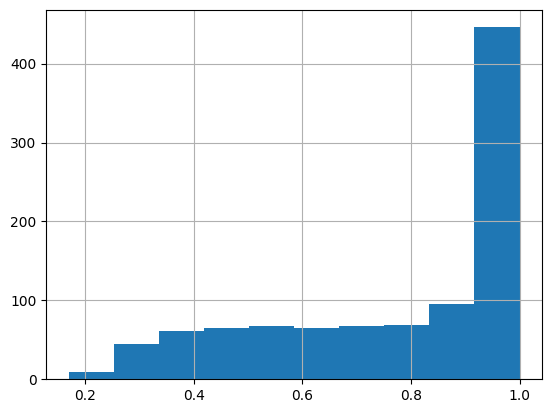

In [53]:
pd.Series(pred_i.max(axis=1)).hist()